In [1]:
#!pip install pymorphy2
#!pip install umap-learn
#!pip install transformers
#!pip install datasets

#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#NLTK libraries
import nltk
import string
import pymorphy2
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('stopwords')
nltk.download('punkt')


# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/artem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/artem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
train_df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [6]:
#checking the null in data
train_df.isnull().sum() 

title      0
is_fake    0
dtype: int64

In [7]:
test_df.isnull().sum() 

title      0
is_fake    0
dtype: int64

In [8]:
train_df['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

<AxesSubplot:xlabel='is_fake', ylabel='count'>

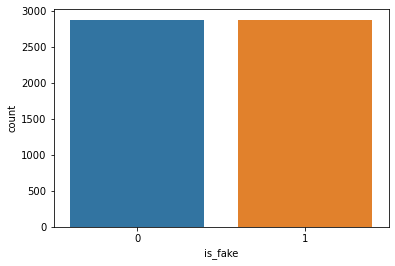

In [9]:
sns.countplot(x = 'is_fake', data=train_df)

The dataset is balanced. We have equal amount of fake and true news (2879).

In [10]:
train_df['length'] = train_df['title'].apply(len)

<AxesSubplot:xlabel='is_fake', ylabel='length'>

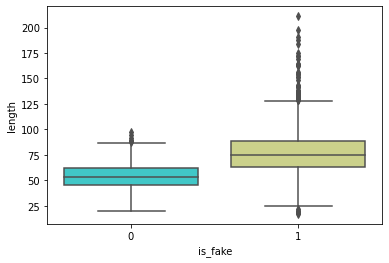

In [11]:
sns.boxplot(x = 'is_fake', y = 'length', data = train_df, palette= 'rainbow')

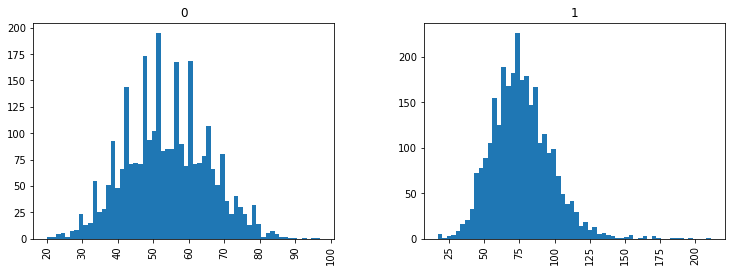

In [12]:
train_df.hist(column='length', by='is_fake',bins=60,figsize=(12,4));

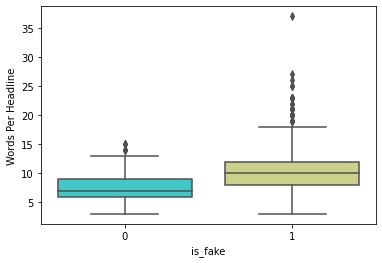

In [13]:
train_df["Words Per Headline"] = train_df["title"].str.split().apply(len)
sns.boxplot(x = 'is_fake', y = 'Words Per Headline', data = train_df, palette= 'rainbow');

Fake news tends to be longer in terms of the news (number of letters and spaces) and number of words. 

## Features and Label

In [14]:
y = train_df['is_fake']
X = train_df['title']

## Train Test Split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

## Dummy Classifier

In [16]:
# Calculation of the simple baseline
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_val, y_val)

0.4991319444444444

## Text preprocessing

In [17]:
def preprocess(text):
    
    # Lowercase
    text = text.lower()
    
    # Removing Punctuation
    text_p = text.translate(str.maketrans('', '', string.punctuation + '«»'))
    
    # Tokenization
    words = word_tokenize(text_p, language='russian')
    
    # Stopword Filtering
    filtered_words = [word for word in words if word not in stopwords.words('russian')]
    
    # Lemmatization
    morph = pymorphy2.MorphAnalyzer()
    lemmatized = [morph.parse(word)[0].normal_form for word in filtered_words]
    
    return " ".join(lemmatized)

In [18]:
X_train_preprocessed = X_train.apply(preprocess)
X_val_preprocessed = X_val.apply(preprocess)

## Vectorization

In [19]:
vectorization = TfidfVectorizer()
X_train_tfidf = vectorization.fit_transform(X_train_preprocessed)
X_val_tfidf = vectorization.transform(X_val_preprocessed)

## Model Comparisons - Naive Bayes,LogisticRegression, LinearSVC, RandomForest

In [20]:
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

In [21]:
log = LogisticRegression(max_iter=1000)
log.fit(X_train_tfidf,y_train)

LogisticRegression(max_iter=1000)

In [22]:
svc = LinearSVC()
svc.fit(X_train_tfidf,y_train)

LinearSVC()

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)

RandomForestClassifier()

## Performance Evaluation

In [24]:
def report(model):
    preds = model.predict(X_val_tfidf)
    print(classification_report(y_val,preds))
    plot_confusion_matrix(model,X_val_tfidf,y_val)

NB MODEL
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       575
           1       0.81      0.91      0.86       577

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



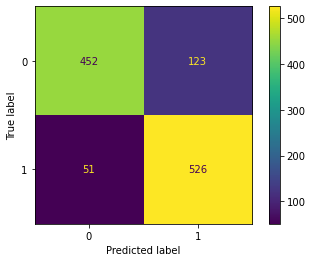

In [25]:
print("NB MODEL")
report(nb)

Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       575
           1       0.85      0.84      0.84       577

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



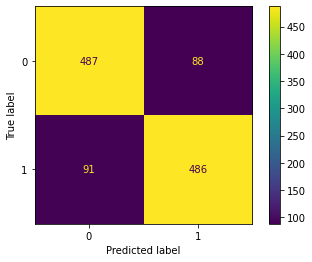

In [26]:
print("Logistic Regression")
report(log)

SVC
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       575
           1       0.84      0.84      0.84       577

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



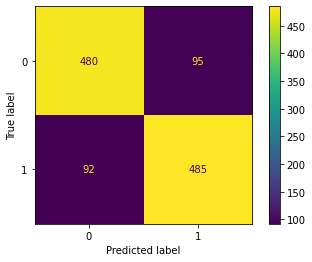

In [27]:
print('SVC')
report(svc)

Random Forest
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       575
           1       0.89      0.66      0.76       577

    accuracy                           0.79      1152
   macro avg       0.81      0.79      0.78      1152
weighted avg       0.81      0.79      0.78      1152



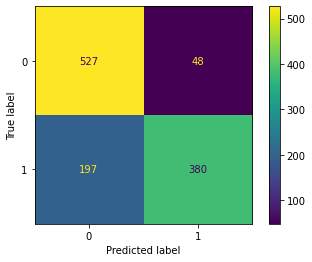

In [28]:
print('Random Forest')
report(rf)

Logistic Regression and NB Model show the best performance in terms of F1 score among 4 explored classifiers. We can try to improve their performance with hyperparameter tuning.

## Logistic Regression with Hyperparameter Tuning



In [29]:
log_model = LogisticRegression(solver='saga', max_iter=1000)

In [30]:
penalty = ['l1','l2']
C = np.logspace(-4, 4, 20)

param_grid = {'penalty': penalty, 'C': C}

In [31]:
log_grid = GridSearchCV(log_model, param_grid = param_grid, n_jobs=-1, verbose=5)

In [32]:
log_grid.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [33]:
log_grid.best_params_

{'C': 4.281332398719396, 'penalty': 'l2'}

Logistic Regression with Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       575
           1       0.84      0.85      0.84       577

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



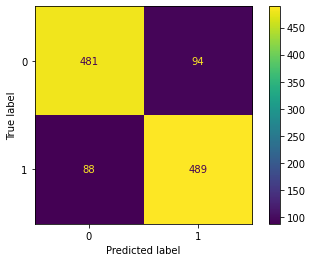

In [34]:
print('Logistic Regression with Hyperparameter Tuning')
report(log_grid)

## Naive Bayes with Hyperparameter Tuning

In [35]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          }

In [36]:
multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [37]:
multinomial_nb_grid.best_params_

{'alpha': 0.5}

Naive Bayes with Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       575
           1       0.81      0.91      0.86       577

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



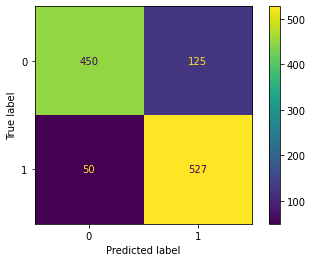

In [38]:
print('Naive Bayes with Hyperparameter Tuning')
report(multinomial_nb_grid)

## Bigrams

In [39]:
vectorization_bigrams = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf_bigrams = vectorization_bigrams.fit_transform(X_train_preprocessed)
X_val_tfidf_bigrams = vectorization_bigrams.transform(X_val_preprocessed)

In [40]:
X_train_tfidf_bigrams.shape

(4606, 25240)

In [41]:
nb_bg = MultinomialNB()
nb_bg.fit(X_train_tfidf_bigrams,y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       575
           1       0.83      0.56      0.67       577

    accuracy                           0.72      1152
   macro avg       0.75      0.73      0.72      1152
weighted avg       0.75      0.72      0.72      1152



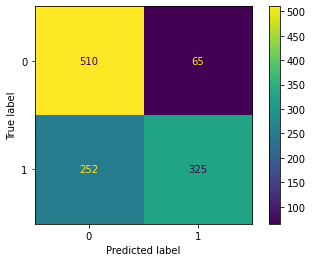

In [42]:
nb_bg_predictions = nb_bg.predict(X_val_tfidf_bigrams)
print(classification_report(y_val,nb_bg_predictions))
plot_confusion_matrix(nb_bg,X_val_tfidf_bigrams,y_val)

Use of bigrams for TF-IDF vectorization led to the worst result in terms of F1 score. 

# TRANSFORMERS

In [43]:
import datasets
from datasets import DatasetDict, Dataset

from transformers import AutoTokenizer, AutoModel

import torch

import umap.umap_ as umap
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

## The Dataset

In [44]:
train = pd.DataFrame(zip(X_train, y_train), columns=[X_train.name, "labels"])
val = pd.DataFrame(zip(X_val, y_val), columns=[X_val.name, "labels"])
test_df.columns = ['title', 'labels']

# Create a DatasetDict object and add to it train, validation and test datasets (by maintaining the same split 
# as in the first approach(TF-IDF + classifier)) 
dataset = DatasetDict()
dataset["train"] = Dataset.from_pandas(train)
dataset["validation"] = Dataset.from_pandas(val)
dataset["test"] = Dataset.from_pandas(test_df)

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'labels'],
        num_rows: 4606
    })
    validation: Dataset({
        features: ['title', 'labels'],
        num_rows: 1152
    })
    test: Dataset({
        features: ['title', 'labels'],
        num_rows: 1000
    })
})

## Tokenization of the dataset

In [46]:
model_ckpt = "bert-base-multilingual-uncased"  

In [47]:
# Load the tokenizer associated with a pretrained model. We use BERT base multilingual model (uncased)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [48]:
# Check the model's maximum content size
tokenizer.model_max_length

512

In [49]:
# Check the names of the fields that the model expects in its forward pass
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [50]:
# Create a function that applies the tokenizer to a batch of examples,padding=True will pad the examples with 
# zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model’s 
# maximum context size

def tokenize(batch):
    return tokenizer(batch["title"], padding=True, truncation=True)

In [51]:
# We can apply this function across all dataset
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [52]:
# This operation has added new input_ids, attention_mask and token_type_ids columns to the dataset

print(dataset_encoded["train"].column_names)

['title', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']


## Training a Text Classifier

We have two options to train a model on our dataset:

- Feature extraction:
we use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

- Fine-tuning:
we train the whole model end-to-end, which also updates the parameters of the pretrained model.

### Transformers as Feature Extractors

#### Using Pretrained Model

We freeze the model body’s weights during training and use the hidden states as features for the classifier. 

In [53]:
# Load the weights of a pretrained BERT model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states.

#### Extracting the last hidden states

In [54]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states 
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  #Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [55]:
# Since the model expects tensors as inputs, we need to convert the input_ids and attention_mask columns to 
# the "torch" format

dataset_encoded.set_format("torch", columns = ['input_ids','attention_mask','labels'])

In [56]:
# Extract the hidden states

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [57]:
# The new hidden state column was created 

dataset_hidden["train"].column_names

['title',
 'labels',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

#### Creating a feature matrix

We will use the hidden states as input features and the labels as targets. 

In [58]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["labels"])
y_valid = np.array(dataset_hidden["validation"]["labels"])
X_train.shape, X_valid.shape

((4606, 768), (1152, 768))

#### Visualizing the training set

Before we train a model on the hidden states, we want to ensure that they provide a useful representations of true and fake news. That's why we will use UMAP algorithm to project vectors from 768 dimensions down to 2.

In [59]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,10.280270,9.880787,0
1,13.008756,5.604662,1
2,12.295201,8.580777,0
3,8.381962,4.441136,0
4,7.448173,10.165980,1


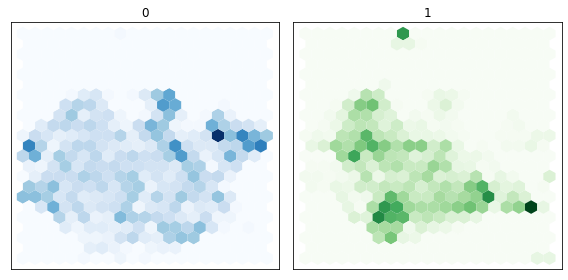

In [60]:
# Plot of the density of points for each category separately

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()
cmaps = ["Blues", "Greens"]
labels = [0,1]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

We see some separation between embeddings for "fake" and "true" news. Fake and true news mostly occupy different regions of the chart.  

#### Training a simple classifier


In [61]:
# Use hidden states to train a logistic model 
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8506944444444444

In [62]:
preds = lr_clf.predict(X_valid)

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       575
           1       0.84      0.87      0.85       577

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



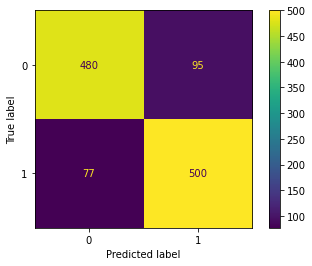

In [63]:
print(classification_report(y_valid,preds))
plot_confusion_matrix(lr_clf,X_valid,y_valid)

So, our simple classifier with BERT multilingual embeddings is significantly better than our baseline, but its results is still comparable to simpler and less computationally expensive TF-IDF + classifier method.


### Fine-Tuning Transformers

With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them.

In [64]:
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained('bert-base-multilingual-uncased', num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

#### Defining the performance metrics



In [65]:
# We will monitor the F1-score and the accuracy of the model during training. 

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [66]:
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-fake_news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  lr_scheduler_type="linear",
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="eval_loss",
                                  greater_is_better=False,
                                  weight_decay=0.01,
                                  save_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  report_to=["wandb"],
                                  push_to_hub=False)

In [67]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: outmetrix_ceo (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.482800,0.342052,0.855035,0.855007
2,0.281700,0.310722,0.879340,0.878990
3,0.197600,0.353192,0.877604,0.877011
4,0.126800,0.297005,0.901910,0.901891
5,0.080500,0.347206,0.902778,0.902746
6,0.051000,0.418913,0.901910,0.901834
7,0.050800,0.406113,0.903646,0.903597
8,0.030400,0.452883,0.897569,0.897427
9,0.024500,0.451429,0.901042,0.901009
10,0.018400,0.455326,0.902778,0.902751


TrainOutput(global_step=720, training_loss=0.13299409759541353, metrics={'train_runtime': 356.3784, 'train_samples_per_second': 129.245, 'train_steps_per_second': 2.02, 'total_flos': 1822568224923600.0, 'train_loss': 0.13299409759541353, 'epoch': 10.0})

In [68]:
preds_output = trainer.predict(dataset_encoded['validation'])

In [69]:
preds_output.metrics

{'test_loss': 0.2970045506954193,
 'test_accuracy': 0.9019097222222222,
 'test_f1': 0.9018908702942343,
 'test_runtime': 1.6016,
 'test_samples_per_second': 719.275,
 'test_steps_per_second': 11.239}

In [70]:
y_preds = np.argmax(preds_output.predictions, axis=1)

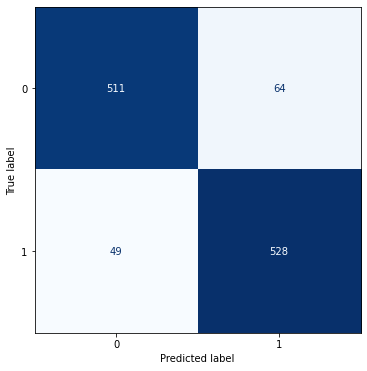

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       575
           1       0.89      0.92      0.90       577

    accuracy                           0.90      1152
   macro avg       0.90      0.90      0.90      1152
weighted avg       0.90      0.90      0.90      1152



In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)
print(classification_report(y_valid,y_preds))

The fine-tuning approach gives us the best result compared to all other explored methods in terms of F1 score.

#### Error analysis

We sort the validation samples by the model loss.

In [72]:
from torch.nn.functional import cross_entropy

In [73]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
        if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [74]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "labels"])
# Compute loss values
dataset_encoded["validation"] = dataset_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/72 [00:00<?, ?ba/s]

In [75]:
dataset_encoded.set_format("pandas")
cols = ["title", "labels", "predicted_label", "loss"]
df = dataset_encoded["validation"][:][cols]

In [76]:
df

,title,labels,predicted_label,loss
0,В РПЦ предложили преподавать предметы в школе ...,1,1,0.022916
1,Берлускони вновь объявил о возвращении Шевченк...,0,0,0.097972
2,NASA: из-за глобального потепления уже через 1...,1,1,0.016977
3,Конституционный суд признал 51-ю статью Консти...,1,1,0.081177
4,Дон Кинг выплатил промоутеру Дениса Лебедева д...,0,0,0.014684
...,...,...,...,...
1147,«Есть множество цветных изображений Петра Перв...,1,1,0.009111
1148,В Париже завели дело о поддельных билетах в Лувр,0,0,0.021496
1149,Суд отклонил иск Навального к оператору систем...,0,0,0.325863
1150,Лидер вологодского движения «Против неизученны...,1,1,0.018676


In [77]:
df.sort_values("loss", ascending=False).head(10)

,title,labels,predicted_label,loss
648,Доллар рухнул после отказа ФНБ от американской...,1,0,4.551557
195,Джо Байден согласился на переговоры с Горбачёвым,1,0,4.428686
878,Аккаунт Трампа заблокировали в Brawl Stars,1,0,4.415525
413,Владимир Путин завершил карьеру хоккеиста,1,0,4.409073
247,Москвичи передохнут от замены плитки,1,0,4.317482
1116,Покупатель футболки сборной Украины останется ...,1,0,4.127089
991,Астрономы обнаружили черные дыры в финансовом ...,1,0,4.103755
1031,В Великобритании начали разыгрывать бензин в л...,1,0,4.094947
676,Мэр Альметьевска пригласил жителей на субботни...,0,1,4.064631
919,Суд в США признал фейком два произведения Гова...,1,0,3.995224


In [78]:
dataset_encoded.reset_format()

## Predictions

In [72]:
test_preds_output = trainer.predict(dataset_encoded['test'])

In [73]:
test_labels = np.argmax(test_preds_output.predictions, axis=1)

In [74]:
test_df['is_fake'] = test_labels

In [75]:
test_df = test_df.drop(columns = "labels", axis=1)

In [82]:
test_df.to_csv("predictions.tsv", sep="\t",index=False)